# 64 Creating Seismic Line Density Maps

This notebook illustrates how to calculate the density of seismic lines (km length per defined area) for a data set provided by the LBEG in Hanover. This workflow can be applied to any other line data to calculate the density of the data. 

<img src="../images/tutorial64_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gemgis as gg
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import shapely
from typing import Union

In [2]:
file_path ='data/64_displaying_seismic_line_density/'
gg.download_gemgis_data.download_tutorial_data(filename="64_displaying_seismic_line_density.zip", dirpath=file_path)

## Loading Outline of Germany

First, we are loading an outline of Germany as reference.

In [3]:
outline_germany = gpd.read_file(file_path + '250_NUTS1.shp')
print(outline_germany.crs)
outline_germany

epsg:25832


,GF,NUTS_LEVEL,NUTS_CODE,NUTS_NAME,geometry
0,4,1,DE1,Baden-Württemberg,"MULTIPOLYGON (((579209.636 5345138.889, 579352..."
1,4,1,DE2,Bayern,"POLYGON ((797853.293 5352195.002, 797799.497 5..."
2,4,1,DE3,Berlin,"POLYGON ((802831.687 5845501.783, 802754.455 5..."
3,4,1,DE4,Brandenburg,"MULTIPOLYGON (((819325.396 5702557.885, 819202..."
4,4,1,DE5,Bremen,"MULTIPOLYGON (((471136.959 5933521.448, 470997..."
5,4,1,DE6,Hamburg,"MULTIPOLYGON (((467342.107 5975636.297, 467364..."
6,4,1,DE7,Hessen,"MULTIPOLYGON (((492728.845 5483452.099, 492466..."
7,4,1,DE8,Mecklenburg-Vorpommern,"MULTIPOLYGON (((790065.392 6006141.945, 790110..."
8,4,1,DE9,Niedersachsen,"MULTIPOLYGON (((541001.526 5719889.433, 541005..."
9,4,1,DEA,Nordrhein-Westfalen,"MULTIPOLYGON (((301890.303 5600399.203, 301901..."


## Loading Seismic Data

The seismic data provided by the LBEG is also loaded as shape file

In [4]:
seismic_data = gpd.read_file(file_path + '2D-Seismik_ETRS89.shp').to_crs('EPSG:25832')
seismic_data['length'] = seismic_data.length 
seismic_data.head()

,ID,ID_SURVEY,SURVEYNAME,S_KURZNAME,LBEG_ARCHI,OPERATOR,OP_LANG,OP_NACHFOL,MESSJAHR,MESSBEGINN,MESSENDE,PROFILNAME,KOORDINATE,ANREGUNG,RECDAUER,SAMPLING,FOLD,EINSICHT,geometry,length
0,182,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-13,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (410508.201 6012745.422, 411210.339...",51178.55
1,185,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-16,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (428189.885 6100261.568, 428149.814...",82392.83
2,187,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-18,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (439890.118 6079493.876, 439879.345...",66871.14
3,188,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-19,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (302758.022 6025567.558, 303708.941...",151224.04
4,189,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-21,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (299479.888 6029068.599, 300252.382...",155473.12


## Plotting Outline of Germany

The seismic data and the outline of Germany are plotted. 

Text(88.88530637344071, 0.5, 'Easting [m]')

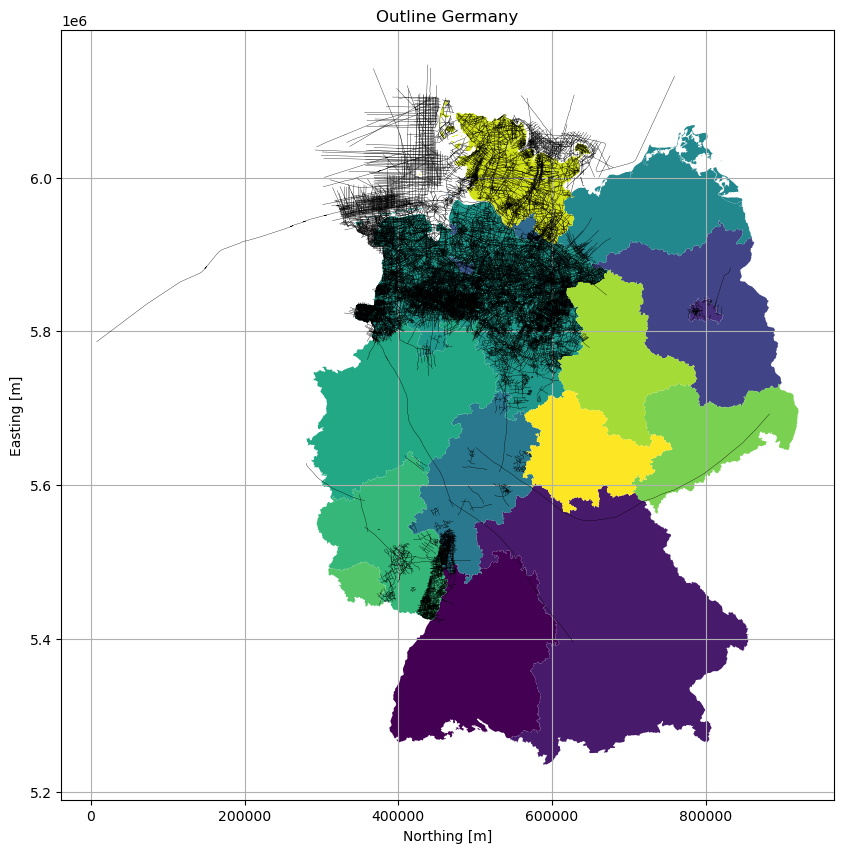

In [5]:
fig, ax = plt.subplots(1, figsize=(10,10))

outline_germany.plot(ax=ax, column='NUTS_CODE', cmap='viridis')
seismic_data.plot(ax=ax, color='black', linewidth=0.25)
plt.grid()
plt.title('Outline Germany')
plt.xlabel('Northing [m]')
plt.ylabel('Easting [m]')

## Filter settings

The data is filtered for data that was acquired after 1972.

In [6]:
cell_size = 5000 # m each side
year = 1972
length = 5000 # m

In [7]:
seismic_data_filtered = seismic_data[seismic_data['MESSJAHR']>year]
print(len(seismic_data_filtered))
seismic_data_filtered.head()

5601


,ID,ID_SURVEY,SURVEYNAME,S_KURZNAME,LBEG_ARCHI,OPERATOR,OP_LANG,OP_NACHFOL,MESSJAHR,MESSBEGINN,MESSENDE,PROFILNAME,KOORDINATE,ANREGUNG,RECDAUER,SAMPLING,FOLD,EINSICHT,geometry,length
0,182,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-13,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (410508.201 6012745.422, 411210.339...",51178.55
1,185,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-16,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (428189.885 6100261.568, 428149.814...",82392.83
2,187,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-18,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (439890.118 6079493.876, 439879.345...",66871.14
3,188,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-19,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (302758.022 6025567.558, 303708.941...",151224.04
4,189,8.00,"ARCO 1991, Blocks E, H, J, K",AR-EHJK-91,"OASYS204070,0123954",ARCO,Arco GmbH Germany,British Petroleum,1991.00,1991-06-01,1991-06-30,AR-EHJK-91-21,Schusskoordinaten,Airgun,7.00,2.00,81.00,Keine Einsicht ohne Erlaubnis des Eigentümers,"LINESTRING (299479.888 6029068.599, 300252.382...",155473.12


## Creating Polygon Mask for Germany

Creating a polygon mask for Germany

In [8]:
from itertools import product

def create_polygon_mask(gdf: gpd.GeoDataFrame,
                        stepsize: int,
                        crs: str = 'EPSG:3034'):
    """Creating a mask GeoDataFrame consisting of squares with a defined stepsize
    Parameters:
    ----------
        gdf: gpd.GeoDataFrame
            GeoDataFrame over which a mask is created
        stepsize: int
            Size of the rasterized squares in meters.
    Returns:
    --------
        gdf_mask: gpd.GeoDataFrame
            GeoDataFrame containing the masked polygons
    """

    # Creating arrays
    x = np.arange(gdf.total_bounds[0], gdf.total_bounds[2], stepsize)
    y = np.arange(gdf.total_bounds[1], gdf.total_bounds[3], stepsize)

    # Creating polygons
    polygons = [Polygon([(a, b), (a + stepsize, b), (a + stepsize, b + stepsize), (a, b + stepsize)]) for a, b in
                product(x, y)]

    # Converting polygons to GeoDataFrame
    gdf_mask = gpd.GeoDataFrame(geometry=polygons,
                                crs=crs)

    return gdf_mask

In [9]:
outline_germany_mask = create_polygon_mask(gdf=outline_germany,
                                           stepsize=cell_size,
                                           crs=outline_germany.crs)
#outline_germany_mask.to_file('outline_germany_mask.shp')
outline_germany_mask

,geometry
0,"POLYGON ((280371.059 5235855.977, 285371.059 5..."
1,"POLYGON ((280371.059 5240855.977, 285371.059 5..."
2,"POLYGON ((280371.059 5245855.977, 285371.059 5..."
3,"POLYGON ((280371.059 5250855.977, 285371.059 5..."
4,"POLYGON ((280371.059 5255855.977, 285371.059 5..."
...,...
22441,"POLYGON ((920371.059 6080855.977, 925371.059 6..."
22442,"POLYGON ((920371.059 6085855.977, 925371.059 6..."
22443,"POLYGON ((920371.059 6090855.977, 925371.059 6..."
22444,"POLYGON ((920371.059 6095855.977, 925371.059 6..."


## Plotting Polygon Mask for Germany

Plotting the polygon mask, seismic data and the outline of Germany. 

Text(87.59722222222221, 0.5, 'Easting [m]')

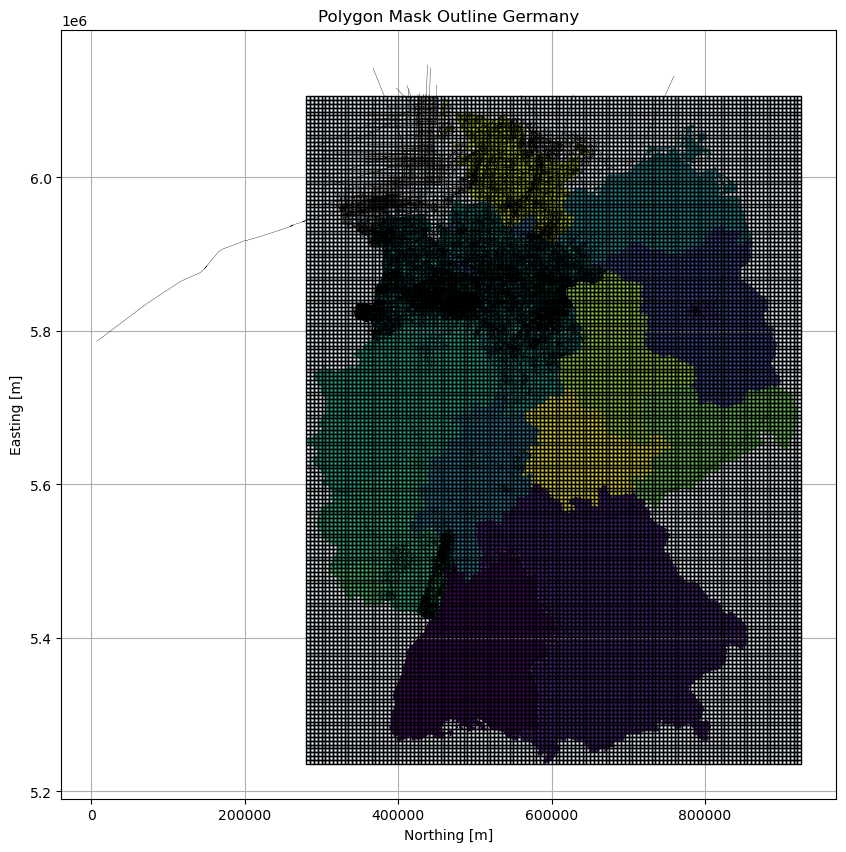

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))

outline_germany.plot(ax=ax, column='NUTS_CODE', cmap='viridis')
outline_germany_mask.plot(ax=ax, alpha=0.1)
outline_germany_mask.boundary.plot(ax=ax, color='black', linewidth=1)
seismic_data.plot(ax=ax, color='black', linewidth=0.25)
plt.grid()
plt.title('Polygon Mask Outline Germany')
plt.xlabel('Northing [m]')
plt.ylabel('Easting [m]')

## Intersect Seismic Data with Mask

Performing spatial join. 

In [11]:
joined = gpd.sjoin(left_df=outline_germany_mask, 
                   right_df=seismic_data_filtered).join(seismic_data_filtered.geometry.rename('line'), 
                                               on='index_right')
joined.head()

,geometry,index_right,ID,ID_SURVEY,SURVEYNAME,S_KURZNAME,LBEG_ARCHI,OPERATOR,OP_LANG,OP_NACHFOL,...,MESSENDE,PROFILNAME,KOORDINATE,ANREGUNG,RECDAUER,SAMPLING,FOLD,EINSICHT,length,line
76,"POLYGON ((280371.059 5615855.977, 285371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."
77,"POLYGON ((280371.059 5620855.977, 285371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."
78,"POLYGON ((280371.059 5625855.977, 285371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."
249,"POLYGON ((285371.059 5610855.977, 290371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."
250,"POLYGON ((285371.059 5615855.977, 290371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."


Assigning the length of the seismic lines to the DataFrame.

In [12]:
joined['length'] = joined.geometry.intersection(joined.line).length
joined.head()

,geometry,index_right,ID,ID_SURVEY,SURVEYNAME,S_KURZNAME,LBEG_ARCHI,OPERATOR,OP_LANG,OP_NACHFOL,...,MESSENDE,PROFILNAME,KOORDINATE,ANREGUNG,RECDAUER,SAMPLING,FOLD,EINSICHT,length,line
76,"POLYGON ((280371.059 5615855.977, 285371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,843.61,"LINESTRING (279995.529 5628459.873, 280200.709..."
77,"POLYGON ((280371.059 5620855.977, 285371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,6446.32,"LINESTRING (279995.529 5628459.873, 280200.709..."
78,"POLYGON ((280371.059 5625855.977, 285371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,1293.79,"LINESTRING (279995.529 5628459.873, 280200.709..."
249,"POLYGON ((285371.059 5610855.977, 290371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,1480.18,"LINESTRING (279995.529 5628459.873, 280200.709..."
250,"POLYGON ((285371.059 5615855.977, 290371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,5957.47,"LINESTRING (279995.529 5628459.873, 280200.709..."


Summing up the lengths and assigning the values to the mask

In [13]:
total_length_per_box = joined.groupby(level=0).length.sum()

In [14]:
outline_germany_mask['length'] = total_length_per_box
outline_germany_mask

,geometry,length
0,"POLYGON ((280371.059 5235855.977, 285371.059 5...",NaN
1,"POLYGON ((280371.059 5240855.977, 285371.059 5...",NaN
2,"POLYGON ((280371.059 5245855.977, 285371.059 5...",NaN
3,"POLYGON ((280371.059 5250855.977, 285371.059 5...",NaN
4,"POLYGON ((280371.059 5255855.977, 285371.059 5...",NaN
...,...,...
22441,"POLYGON ((920371.059 6080855.977, 925371.059 6...",NaN
22442,"POLYGON ((920371.059 6085855.977, 925371.059 6...",NaN
22443,"POLYGON ((920371.059 6090855.977, 925371.059 6...",NaN
22444,"POLYGON ((920371.059 6095855.977, 925371.059 6...",NaN


Create GeoDataFrame from Data

In [15]:
gdf_buffered = gpd.GeoDataFrame(geometry=[outline_germany_mask[outline_germany_mask['length']>0].unary_union.buffer(5000)])
gdf_buffered

,geometry
0,"MULTIPOLYGON (((296047.173 5958355.977, 295961..."


## Plotting results

Plotting the seismic line density

<AxesSubplot: >

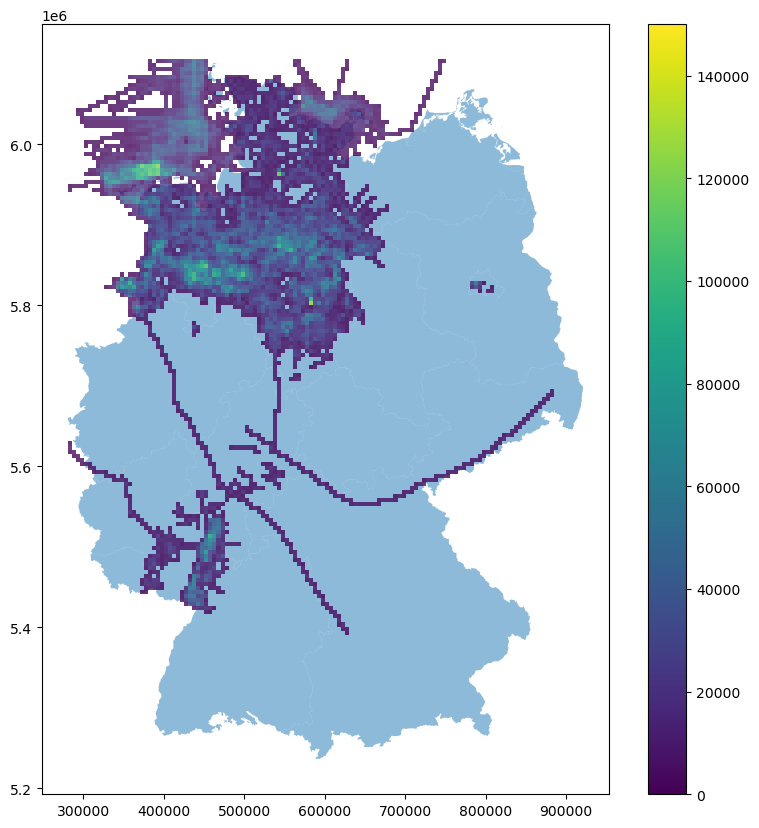

In [16]:
fig, ax = plt.subplots(1, figsize=(10,10))
outline_germany.plot(ax=ax, alpha=0.5)
# outline_germany_mask.plot(ax=ax, alpha=0.1)
# gdf_buffered.plot(ax=ax)
outline_germany_mask[outline_germany_mask['length']>0].plot(ax=ax, alpha=0.8, column='length', legend=True, vmin=0, vmax=150000)
# outline_germany_mask.boundary.plot(ax=ax, color='black', linewidth=1)


## Merging Outline

In [17]:
gdf = gpd.GeoDataFrame(geometry=[outline_germany.unary_union], crs='EPSG:25832')
gdf

,geometry
0,"MULTIPOLYGON (((356678.002 5449479.768, 356695..."


## Creating Hexagon Grid

In [18]:
hex_gdf = gg.vector.create_hexagon_grid(gdf=outline_germany.explode(),radius=5000, crop_gdf=True).drop_duplicates()
hex_gdf.head()

,geometry
0,"POLYGON ((282871.059 5664144.049, 277871.059 5..."
1,"POLYGON ((282871.059 5655483.795, 277871.059 5..."
2,"POLYGON ((290371.059 5755076.716, 285371.059 5..."
3,"POLYGON ((290371.059 5746416.462, 285371.059 5..."
4,"POLYGON ((290371.059 5737756.208, 285371.059 5..."


In [19]:
hex_gdf.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Plotting Hexagon Grid

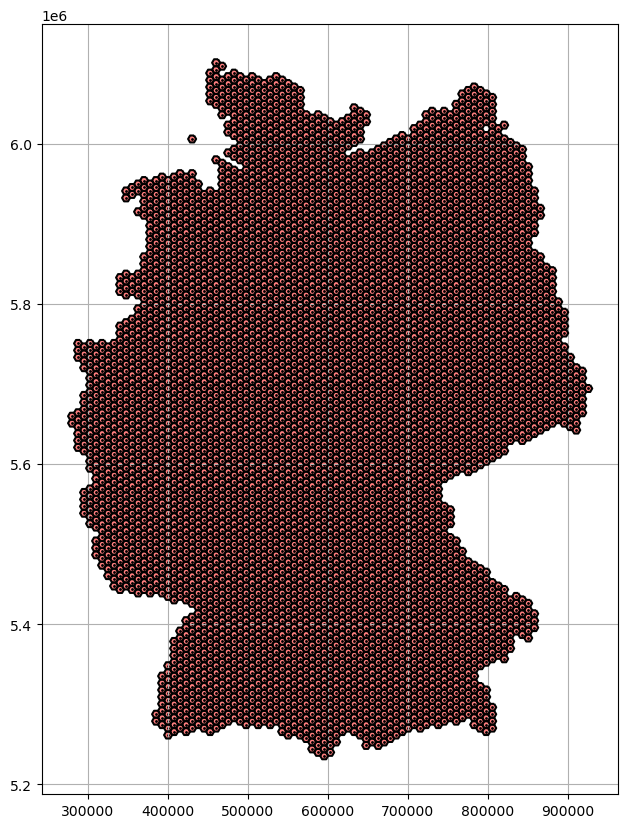

In [20]:
fig, ax = plt.subplots(1, figsize=(10,10))


# polygon_gdf.plot(ax=ax)
hex_gdf.plot(ax=ax, color='red', alpha=0.5)
hex_gdf.exterior.plot(ax=ax, color='black')
hex_gdf.centroid.plot(ax=ax, color='black', markersize=1)
plt.grid()

## Calculating seismic line density

In [21]:
joined = gpd.sjoin(left_df=hex_gdf, 
                   right_df=seismic_data_filtered).join(seismic_data_filtered.geometry.rename('line'), 
                                               on='index_right')
joined.head()

,geometry,index_right,ID,ID_SURVEY,SURVEYNAME,S_KURZNAME,LBEG_ARCHI,OPERATOR,OP_LANG,OP_NACHFOL,...,MESSENDE,PROFILNAME,KOORDINATE,ANREGUNG,RECDAUER,SAMPLING,FOLD,EINSICHT,length,line
10,"POLYGON ((290371.059 5625172.906, 285371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."
41,"POLYGON ((305371.059 5607852.397, 300371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."
60,"POLYGON ((312871.059 5603522.270, 307871.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."
81,"POLYGON ((320371.059 5599192.143, 315371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."
102,"POLYGON ((327871.059 5594862.016, 322871.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,93317.75,"LINESTRING (279995.529 5628459.873, 280200.709..."


In [22]:
joined['length'] = joined.geometry.intersection(joined.line).length
joined.head()

,geometry,index_right,ID,ID_SURVEY,SURVEYNAME,S_KURZNAME,LBEG_ARCHI,OPERATOR,OP_LANG,OP_NACHFOL,...,MESSENDE,PROFILNAME,KOORDINATE,ANREGUNG,RECDAUER,SAMPLING,FOLD,EINSICHT,length,line
10,"POLYGON ((290371.059 5625172.906, 285371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,7712.61,"LINESTRING (279995.529 5628459.873, 280200.709..."
41,"POLYGON ((305371.059 5607852.397, 300371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,8676.04,"LINESTRING (279995.529 5628459.873, 280200.709..."
60,"POLYGON ((312871.059 5603522.270, 307871.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,8718.85,"LINESTRING (279995.529 5628459.873, 280200.709..."
81,"POLYGON ((320371.059 5599192.143, 315371.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,8697.56,"LINESTRING (279995.529 5628459.873, 280200.709..."
102,"POLYGON ((327871.059 5594862.016, 322871.059 5...",3371,10958,1308.00,DEKORP-87,DEKORP-87,None,GFZ,GeoForschungsZentrum Potsdam,None,...,1987-08-31,DEKORP`87-1A,None,Vibrator,16.00,4.00,200.00,Keine Einsicht ohne Erlaubnis des Eigentümers,8730.73,"LINESTRING (279995.529 5628459.873, 280200.709..."


In [23]:
total_length_per_box = joined.groupby(level=0).length.sum()

In [24]:
outline_germany_mask = hex_gdf
outline_germany_mask['length'] = total_length_per_box
outline_germany_mask

,geometry,length
0,"POLYGON ((282871.059 5664144.049, 277871.059 5...",NaN
1,"POLYGON ((282871.059 5655483.795, 277871.059 5...",NaN
2,"POLYGON ((290371.059 5755076.716, 285371.059 5...",NaN
3,"POLYGON ((290371.059 5746416.462, 285371.059 5...",NaN
4,"POLYGON ((290371.059 5737756.208, 285371.059 5...",NaN
...,...,...
6873,"POLYGON ((845371.059 5997563.829, 840371.059 5...",NaN
6874,"POLYGON ((845371.059 5988903.575, 840371.059 5...",NaN
6894,"POLYGON ((845371.059 5980243.321, 840371.059 5...",NaN
6897,"POLYGON ((852871.059 5975913.194, 847871.059 5...",NaN


## Plotting seismic line density

<AxesSubplot: >

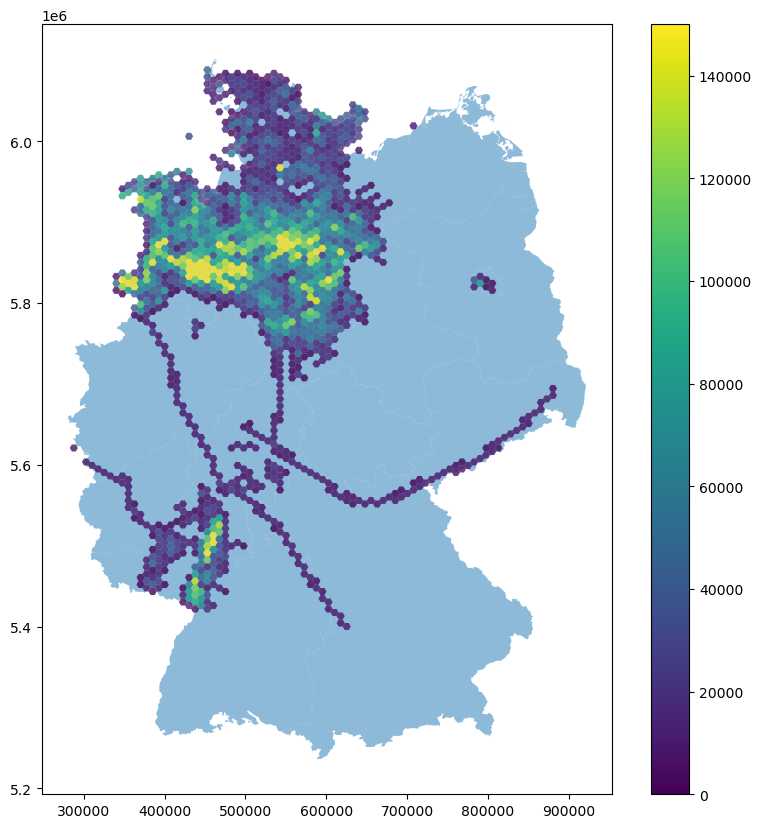

In [25]:
fig, ax = plt.subplots(1, figsize=(10,10))
outline_germany.plot(ax=ax, alpha=0.5)
# outline_germany_mask.plot(ax=ax, alpha=0.1)
# gdf_buffered.plot(ax=ax)
outline_germany_mask[outline_germany_mask['length']>0].plot(ax=ax, alpha=0.8, column='length', legend=True, vmin=0, vmax=150000)
# outline_germany_mask.boundary.plot(ax=ax, color='black', linewidth=1)
